## Dataset $-$ https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In [1]:
import pandas as pd 
import torch 
import torch.nn as nn 
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.functional as F

In [3]:
df = pd.read_csv('creditcard.csv')
print(f"df shape: {df.shape}")
df.head()

df shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.Class.value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [7]:
# keep all fraud transactions and 9500 non-fraud transactions
df_balanced = pd.concat([df[df.Class == 1], df[df.Class == 0].sample(n=9500, random_state=42)], axis=0)
df_balanced.Class.value_counts()

Class
0    9500
1     492
Name: count, dtype: int64

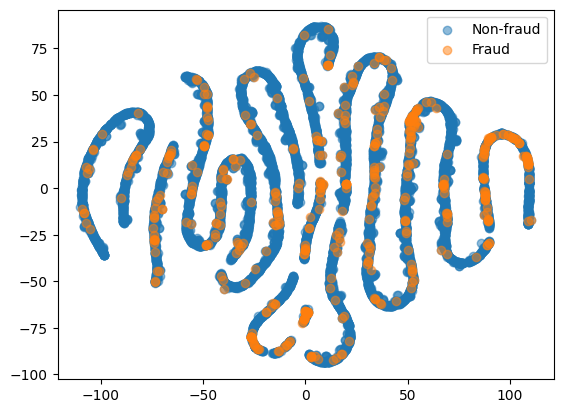

In [11]:
# use TSNE to visualize the df_balanced using 2 components
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
X = df_balanced.drop('Class', axis=1)
y = df_balanced.Class
X_tsne = tsne.fit_transform(X)
plt.scatter(X_tsne[y==0][:, 0], X_tsne[y==0][:, 1], label='Non-fraud', alpha=0.5)
plt.scatter(X_tsne[y==1][:, 0], X_tsne[y==1][:, 1], label='Fraud', alpha=0.5)
plt.legend()
plt.show()

In [33]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.tensorboard import SummaryWriter
# from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader, TensorDataset
writer = SummaryWriter('runs/autoencoder_experiment') 
# Split the full dataset into train (70%), and temporary (30%)
train_df, temp_df = train_test_split(df_balanced, test_size=0.3, random_state=42, shuffle=True)
# Split the temporary set equally into validation (15%) and test (15%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, shuffle=True)

print(f"train shape: {train_df.shape}, val shape: {val_df.shape}, test shape: {test_df.shape}")
# For training, use only non-fraud samples
train_df = train_df[train_df['Class'] == 0]
print(f"train shape after filtering: {train_df.shape}")
# Define the features – assuming all columns except 'Class' are features
feature_cols = train_df.columns.drop('Class')

# Preprocessing: normalize using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(train_df[feature_cols])
X_val = scaler.transform(val_df[feature_cols])
X_test = scaler.transform(test_df[feature_cols])

# Convert to PyTorch tensors as float16
X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
X_val_tensor = torch.tensor(X_val, dtype=torch.float64)
X_test_tensor = torch.tensor(X_test, dtype=torch.float64)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a simple autoencoder with ELU activations and MSE loss
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, input_dim // 2),
            nn.ELU(),
            nn.Linear(input_dim // 2, input_dim // 4),
            nn.ELU(),
            nn.Linear(input_dim // 4, hidden_dim),
            nn.ELU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, input_dim // 4),
            nn.ELU(),
            nn.Linear(input_dim // 4, input_dim // 2),
            nn.ELU(),
            nn.Linear(input_dim // 2, input_dim ),
            nn.ELU(),
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Set dimensions
input_dim = X_train.shape[1]
hidden_dim = 2

# Initialize model and convert to device
model = Autoencoder(input_dim, hidden_dim).to(device)
dummy_input = torch.randn(1, input_dim).double().to(device)  # Example input
writer.add_graph(model.double(), dummy_input)  # <-- Add model visualization
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Create DataLoader for training data
batch_size = 64
train_dataset = TensorDataset(X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Move validation and test tensors to device
X_val_tensor = X_val_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)


num_epochs = 50 
for epoch in range(num_epochs):
    model.train().double()
    running_loss = 0.0  
    for batch in train_loader:
        inputs = batch[0].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    # weighted loss
    epoch_loss = running_loss / len(train_loader.dataset)
    
    # Evaluate on the validation set
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, X_val_tensor).item()
        # Log to TensorBoard  # <-- New logging section
    writer.add_scalar('Loss/train', epoch_loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Final evaluation on test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, X_test_tensor).item()
print(f"\nTest Loss: {test_loss:.4f}")

train shape: (6994, 31), val shape: (1499, 31), test shape: (1499, 31)
train shape after filtering: (6671, 31)
Epoch 1/50, Training Loss: 0.9999, Validation Loss: 2.6164
Epoch 2/50, Training Loss: 0.9397, Validation Loss: 2.5805
Epoch 3/50, Training Loss: 0.9216, Validation Loss: 2.5666
Epoch 4/50, Training Loss: 0.9137, Validation Loss: 2.5560
Epoch 5/50, Training Loss: 0.9093, Validation Loss: 2.5500
Epoch 6/50, Training Loss: 0.9059, Validation Loss: 2.5487
Epoch 7/50, Training Loss: 0.9026, Validation Loss: 2.5448
Epoch 8/50, Training Loss: 0.8988, Validation Loss: 2.5433
Epoch 9/50, Training Loss: 0.8943, Validation Loss: 2.5381
Epoch 10/50, Training Loss: 0.8891, Validation Loss: 2.5325
Epoch 11/50, Training Loss: 0.8828, Validation Loss: 2.5250
Epoch 12/50, Training Loss: 0.8745, Validation Loss: 2.5160
Epoch 13/50, Training Loss: 0.8642, Validation Loss: 2.5036
Epoch 14/50, Training Loss: 0.8536, Validation Loss: 2.4923
Epoch 15/50, Training Loss: 0.8451, Validation Loss: 2.487

In [35]:
tensorboard --logdir=runs/

Reusing TensorBoard on port 6007 (pid 55540), started 0:00:52 ago. (Use '!kill 55540' to kill it.)

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X = df_balanced.drop('Class', axis=1)
y = df_balanced['Class']
# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
# Scale all data using non-fraud scaler
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Move scaled data to the same device as the model
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float64).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float64).to(device)

# Get encoded features
train_features = model.encoder(X_train_tensor).detach().cpu().numpy()
test_features = model.encoder(X_test_tensor).detach().cpu().numpy()

# 4. Train Logistic Regression
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(train_features, y_train)

# 5. Evaluate
y_pred = lr.predict(test_features)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.79      0.87      2850
           1       0.12      0.57      0.20       148

    accuracy                           0.78      2998
   macro avg       0.55      0.68      0.54      2998
weighted avg       0.93      0.78      0.84      2998

